<a href="https://colab.research.google.com/github/wakamatsuikuma/MEMO_causal_analysis_by_python/blob/main/%E7%AC%AC5%E7%AB%A0_3_doubly_robust_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# メモ
【DR-Learnerによる介入効果の推定】  
1. T-learner的に潜在的結果変数を機械学習モデルで求める　　
2. 結果変数側を傾向スコアと1の機械学習モデル推定値で調整する
3. 介入有り無しでそれぞれのITEを求める
4. 3で求められたITEと共変量でモデル構築
5. 共変量で介入効果を推定する  
(5で再度ITEを推定して、それを介入効果としているのがよくわからない)  

【X-LearnerとDR-Learnerの違い】  
傾向スコアの使い方が異なる。  

X-Learnerは、  
1. T-Learner的に算出したITTおよびITUを目的変数に、共変量を説明変数としてモデル構築
2. そのモデルに再度共変量を入力して、ITEを推定
3. 推定したITEを介入有り無しで逆側の傾向スコアで加重平均して、介入効果を求める  (逆側の傾向スコアを重みづけることで、介入有り無しについてよりフラットな状況としているということ？)

DR-Learnerは、
1. T-Learner的にITTとITUを算出する際に、結果変数側を傾向スコアと推定結果変数で調整して算出する(精度良く推定しながら、推定誤差も調整することで、個別の誤差を少しでも緩和している？)
2. 算出したITTとITUを目的変数に、共変量を説明変数にしてモデル構築
3. そのモデルに再度共変量を入力して、ITEを推定



# 5.3 Doubly Robust Learningの実装

【DR-Learnerによる介入効果の推定】  
1. T-learner的に潜在的結果変数を機械学習モデルで求める　　
2. 結果変数側を傾向スコアと1の機械学習モデル推定値で調整する
3. 介入有り無しでそれぞれのITEを求める
4. 3で求められたITEと共変量でモデル構築
5. 共変量で介入効果を推定する  
(5で再度ITEを推定して、それを介入効果としているのがよくわからん)  

【X-LearnerとDR-Learnerの違い】  
傾向スコアの使い方が異なる。  
X-Learnerは、  
1. T-Learner的に算出したITTおよびITUを目的変数に、共変量を説明変数としてモデル構築
2. そのモデルに再度共変量を入力して、ITEを推定
3. 推定したITEを介入有り無しで逆側の傾向スコアで加重平均して、介入効果を求める  (逆側の傾向スコアを重みづけることで、介入有り無しについてよりフラットな状況としているということか？)


DR-Learnerは、
1. T-Learner的にITTとITUを算出する際に、結果変数側を傾向スコアと推定結果変数で調整して算出する(精度良く推定しながら、推定誤差も調整することで、個別の誤差を少しでも緩和している？)
2. 算出したITTとITUを目的変数に、共変量を説明変数にしてモデル構築
3. そのモデルに再度共変量を入力して、ITEを推定

## 各種設定とライブラリのインポート

In [ ]:
# 乱数のシードを設定
import random
import numpy as np

np.random.seed(1234)
random.seed(1234)

# 使用するパッケージ（ライブラリと関数）を定義
# 標準正規分布の生成用
from numpy.random import *

# グラフの描画用
import matplotlib.pyplot as plt

# SciPy 平均0、分散1に正規化（標準化）関数
import scipy.stats

# シグモイド関数をimport
from scipy.special import expit

# その他
import pandas as pd

## データの生成

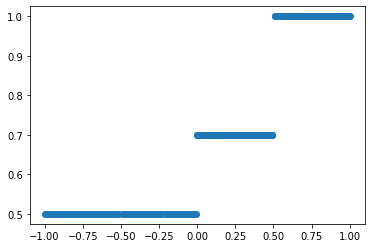

In [ ]:
# データ数
num_data = 500

# 部下育成への熱心さ
x = np.random.uniform(low=-1, high=1, size=num_data)  # -1から1の一様乱数

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
e_z = randn(num_data)  # ノイズの生成
z_prob = expit(-1*-5.0*x+5*e_z)  # xの効果が反対になっていたのを修正Issue：#18
Z = np.array([])

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
for i in range(num_data):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)

# 介入効果の非線形性：部下育成の熱心さxの値に応じて段階的に変化
t = np.zeros(num_data)
for i in range(num_data):
    if x[i] < 0:
        t[i] = 0.5
    elif x[i] >= 0 and x[i] < 0.5:
        t[i] = 0.7
    elif x[i] >= 0.5:
        t[i] = 1.0

e_y = randn(num_data)
Y = 2.0 + t*Z + 0.3*x + 0.1*e_y 

# 介入効果を図で確認
plt.scatter(x, t, label="treatment-effect")

## データをまとめた表を作成し、可視化

x    Z    t         Y
0 -0.616961  0.0  0.5  1.803183
1  0.244218  1.0  0.7  2.668873
2 -0.124545  0.0  0.5  2.193123
3  0.570717  1.0  1.0  3.245229
4  0.559952  1.0  1.0  3.139868

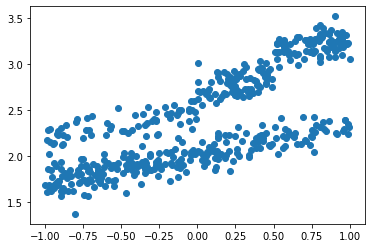

In [ ]:
df = pd.DataFrame({'x': x,
                   'Z': Z,
                   't': t,
                   'Y': Y,
                   })

display(df.head())  # 先頭を表示

plt.scatter(x, Y)

## DR-Learner

### まずはT-Learner

In [ ]:
# ランダムフォレストモデルを作成
from sklearn.ensemble import RandomForestRegressor

# 集団を2つに分ける
df_0 = df[df.Z == 0.0]  # 介入を受けていない集団
df_1 = df[df.Z == 1.0]  # 介入を受けた集団

# 介入を受けていないモデル
M_0 = RandomForestRegressor(max_depth=3)
M_0.fit(df_0[["x"]], df_0[["Y"]])

# 介入を受けたモデル
M_1 = RandomForestRegressor(max_depth=3)
M_1.fit(df_1[["x"]], df_1[["Y"]])


<ipython-input-5-bb3821e6ba86>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  M_0.fit(df_0[["x"]], df_0[["Y"]])
<ipython-input-5-bb3821e6ba86>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  M_1.fit(df_1[["x"]], df_1[["Y"]])


RandomForestRegressor(max_depth=3)

### 傾向スコア算出

In [ ]:
# 傾向スコアを求めます
from sklearn.linear_model import LogisticRegression

# 説明変数
X = df[["x"]]

# 被説明変数（目的変数）
Z = df["Z"]

# 回帰の実施
g_x = LogisticRegression().fit(X, Z)
g_x_val = g_x.predict_proba(X)

### DR法に基づく推定

In [ ]:
# 処置群
Y_1 = M_1.predict(df_1[["x"]]) + (df_1["Y"] - M_1.predict(df_1[["x"]])) / \
    g_x.predict_proba(df_1[["x"]])[:, 1]  # [:,1]はZ=1側の確率
df_1["ITE"] = Y_1 - M_0.predict(df_1[["x"]])

# 非処置群
Y_0 = M_0.predict(df_0[["x"]]) + (df_0["Y"] - M_0.predict(df_0[["x"]])) / \
    g_x.predict_proba(df_0[["x"]])[:, 0]  # [:,0]はZ=0側の確率
df_0["ITE"] = M_1.predict(df_0[["x"]]) - Y_0

# 表を結合する
df_DR = pd.concat([df_0, df_1])
df_DR.head()


<ipython-input-7-aa7e8f9283b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["ITE"] = Y_1 - M_0.predict(df_1[["x"]])
<ipython-input-7-aa7e8f9283b4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0["ITE"] = M_1.predict(df_0[["x"]]) - Y_0


x    Z    t         Y       ITE
0 -0.616961  0.0  0.5  1.803183  0.514190
2 -0.124545  0.0  0.5  2.193123  0.081865
5 -0.454815  0.0  0.5  1.973293  0.333970
6 -0.447071  0.0  0.5  1.953387  0.364906
9  0.751865  0.0  1.0  2.289369  0.776072

<ipython-input-8-03abd08a687e>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  M_DR.fit(df_DR[["x"]], df_DR[["ITE"]])


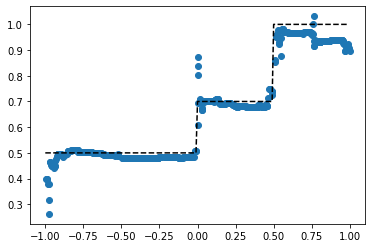

In [ ]:
# モデルM_DRを構築し、各人の治療効果をモデルから求める

# モデルM_DR
M_DR = RandomForestRegressor(max_depth=3)
M_DR.fit(df_DR[["x"]], df_DR[["ITE"]])


# 推定された治療効果を各人ごとに求めます
t_estimated = M_DR.predict(df_DR[["x"]])
plt.scatter(df_DR[["x"]], t_estimated,
            label="estimated_treatment-effect")

# 正解のグラフを作成
x_index = np.arange(-1, 1, 0.01)
t_ans = np.zeros(len(x_index))
for i in range(len(x_index)):
    if x_index[i] < 0:
        t_ans[i] = 0.5
    elif x_index[i] >= 0 and x_index[i] < 0.5:
        t_ans[i] = 0.7
    elif x_index[i] >= 0.5:
        t_ans[i] = 1.0


# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')